## Exercise 1.4 Hotdog -- no hotdog
This is the first poster hand-in exercise for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from numba import jit

In [2]:
# Set the seed
seed = 42
torch.manual_seed(seed)
torch.mps.manual_seed(seed)

We always check that we are running on a GPU

In [77]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator


In [3]:
if torch.backends.mps.is_available():
    print("The code will run on GPU.")
else:
    print ("MPS device not found.")

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [4]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [33]:
size = 128
#train_transform = transforms.Compose([transforms.Resize((size, size)),
#                                    transforms.ToTensor(),
#                                    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

#test_transform = transforms.Compose([transforms.Resize((size, size)), 
#                                    transforms.ToTensor(),
#                                    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    #torchvision.transforms.Resize((size, size)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(30),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    #torchvision.transforms.Resize((size, size)),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

test_transform_2 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((size, size)),
    torchvision.transforms.ToTensor(),
    transforms.Normalize(mean=[0.5226, 0.4412, 0.3585], std=[0.2253, 0.2294, 0.2339])])

batch_size = 1
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
testset_our_model = Hotdog_NotHotdog(train=False, transform=test_transform_2) 
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_our_model = DataLoader(testset_our_model, batch_size=batch_size, shuffle=False, num_workers=0)

In [34]:
class Network(nn.Module):
    def __init__(self, num_epochs, learning_rate, batch_size, Adam_optimizer = True, batch_norm= False, dropout= False, extra_layer = False):
        super(Network, self).__init__()
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        self.criterion = nn.CrossEntropyLoss()

        # Convolutional layers
        layers = [nn.Conv2d(3, 32, kernel_size=3, padding=1)]
        if batch_norm:
            layers.append(nn.BatchNorm2d(32))
        layers.extend([
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, kernel_size=3, padding=1)
        ])
        if batch_norm:
            layers.append(nn.BatchNorm2d(32))
        layers.extend([
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])
        if extra_layer:
            layers.extend([
                nn.Conv2d(32, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.MaxPool2d(2)
                ])
        
        self.convolutional = nn.Sequential(*layers)

        linear_layers = [
            nn.Linear(32*16*16, 128),
            nn.ReLU()]
        if dropout:
            linear_layers.append(nn.Dropout(0.3))
        linear_layers.extend([
            nn.Linear(128, 2)
        ])
        self.linear = nn.Sequential(*linear_layers)
        
        if Adam_optimizer:
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)

        
    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x
    
    def run(self, train_loader, test_loader):
        losses = []
        train_accuracy = []
        test_accuracy = []
        for epoch in tqdm(range(self.num_epochs), unit= 'epoch'):
            train_correct = 0
            loss_total = 0

            for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
                self.train()
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self(data)
                loss = self.criterion(output, target)
                loss_total+= loss.detach().cpu().item()
                loss.backward()
                self.optimizer.step()
                predicted = output.argmax(dim=1)
                train_correct += (target == predicted).sum().cpu().item()

        #test accuracy
            test_correct = 0
            for data, target in test_loader:
                self.eval()
                data = data.to(device)
                with torch.no_grad():
                    output = self(data)
                predicted = output.argmax(dim=1).cpu()
                test_correct += (predicted == target).sum().cpu().item()
                
            test_acc, train_acc= test_correct/len(testset), train_correct/len(trainset)
            test_accuracy.append(test_acc)
            train_accuracy.append(train_acc)
            print("Epoch: {epoch} \t Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(epoch = epoch+1, test=100*test_acc, train=100*train_acc))
            losses.append(loss_total/len(train_loader))

        return losses, train_accuracy, test_accuracy

best_model = Network(10, 0.001, batch_size, Adam_optimizer= True, batch_norm= True, dropout=True, extra_layer= True)

In [35]:
finetuned_model = torchvision.models.resnet18(pretrained=False)
finetuned_model.fc = nn.Linear(finetuned_model.fc.in_features, 2)

/Users/hendrikschmidt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hendrikschmidt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [36]:
finetuned_model.load_state_dict(torch.load('finetune_net.pth'))
best_model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [37]:
finetuned_model.to(device)
best_model.to(device)

finetuned_model.eval()
best_model.eval()

Network(
  (criterion): CrossEntropyLoss()
  (convolutional): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, in

In [38]:
def compute_naive_saliency_map(model, image):
    model.eval()
    image = image.to(device)
    image.requires_grad_()
    output = model(image)
    output[0, output.argmax()].backward()
    saliency_map = image.grad.abs().max(dim=1)[0]
    return saliency_map

In [43]:
def compute_smoothgrad_saliency_map(model, image, n=100, sigma=0.1):
    saliency_maps = []
    for _ in range(n):
        #noise = torch.randn_like(image) * sigma
        noisy_input = image + (sigma * torch.randn_like(image))
        noisy_input = torch.clamp(noisy_input, 0, 1)
        saliency_map = compute_naive_saliency_map(model, image)
        saliency_maps.append(saliency_map)
    return torch.stack(saliency_maps).mean(dim=0)

tensor([0])


(-0.5, 127.5, 127.5, -0.5)

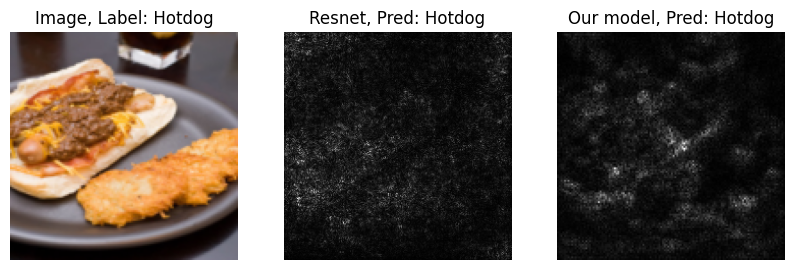

In [67]:
#get the first image from the test set
indx = 1230
idx = 0
for image, target in test_loader:
    idx += 1
    if idx == indx:
        break
idx = 0
for image2, target2 in test_loader_our_model:
    idx += 1
    if idx == indx:
        break

saliency_map = compute_smoothgrad_saliency_map(finetuned_model, image)
saliency_map_best = compute_smoothgrad_saliency_map(best_model, image2)

output_resnet = finetuned_model(image.to(device))
output_best = best_model(image2.to(device))

mean=[0.5226, 0.4412, 0.3585]
std=[0.2253, 0.2294, 0.2339]
# renormalise the image
image2 = image2 * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)

print(target)
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image2[0].permute(1, 2, 0).cpu().numpy())
plt.title('Image, Label: {}'.format('Hotdog' if target2[0] == 0 else 'Not hotdog'))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency_map[0].cpu().numpy(), cmap='gray')
plt.title('Resnet, Pred: {}'.format('Hotdog' if output_resnet.argmax() == 0 else 'Not hotdog'))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(saliency_map_best[0].cpu().numpy(), cmap='gray')
plt.title('Our model, Pred: {}'.format('Hotdog' if output_best.argmax() == 0 else 'Not hotdog'))
plt.axis('off')

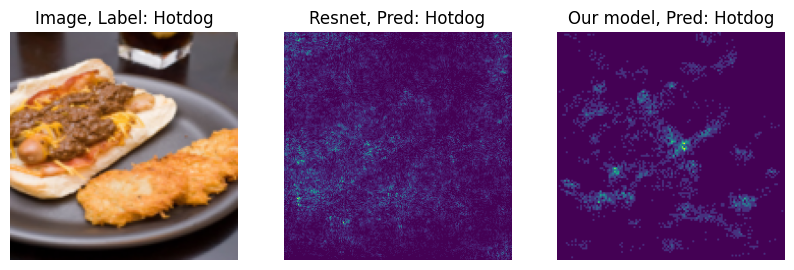

In [70]:
# multiply the saliency map with the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image2[0].permute(1, 2, 0).cpu().numpy())
plt.title('Image, Label: {}'.format('Hotdog' if target2[0] == 0 else 'Not hotdog'))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow((saliency_map[0].cpu().numpy() *255).astype(np.uint8))
plt.title('Resnet, Pred: {}'.format('Hotdog' if output_resnet.argmax() == 0 else 'Not hotdog'))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow((saliency_map_best[0].cpu().numpy() * 255).astype(np.uint8))
plt.title('Our model, Pred: {}'.format('Hotdog' if output_best.argmax() == 0 else 'Not hotdog'))
plt.axis('off')
plt.show()

700, 900, 1000, 1050, 1055, 1060, 1070, 1080, 1090, 1100, 1150, 

Let's look at some images from our data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


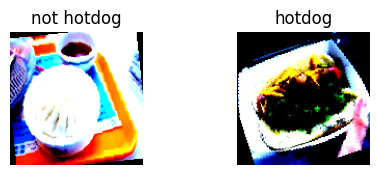

In [6]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(batch_size):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [89]:
class ResNetBlock(nn.Module):
    def __init__(self, c_in, act_fn=nn.ReLU, c_out=-1, channel_change=False, strides=1):
        '''
        Args:
            c_in: number of input features
            act_fn: activation function
            c_out: number of output features
        '''
        super().__init__()

        self.act_fn = act_fn()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
            self.act_fn,
            nn.Conv2d(in_channels=c_out, out_channels=c_out, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_out),
        )
        
        if channel_change:
            self.conv3 = nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None

    def forward(self, x):
        z = self.net(x)
        if self.conv3:
            x = self.conv3(x)
        out = x + z
        out = self.act_fn(out)
        return out

In [90]:
block = ResNetBlock(c_in=64, c_out=64)
x = torch.randn(1, 64, 32, 32 )
x = x.to(device)  # Batch size 1, 64 channels, 32x32 image
block = block.to(device)
out = block(x)
print(out.shape) # Should output (1, 64, 32, 32)

torch.Size([1, 64, 32, 32])


In [91]:
class Network(nn.Module):
    def __init__(self, num_classes=10, num_blocks=[2,2,2,2], c_hidden=[16,32,32,32], act_fn_name="relu",):
        super(Network, self).__init__()

        self.act_fn_name = act_fn_name

        if act_fn_name == "relu":
            act_fn = nn.ReLU
        elif act_fn_name == "leaky_relu":
            act_fn = nn.LeakyReLU
        else:
            raise ValueError("Unknown activation function")
        
        self.input_net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=c_hidden[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_hidden[0]),
            act_fn()
        )


        resnet_blocks = []
        channel_change = False
        for idx, block_size in enumerate(num_blocks):
            c_in = c_hidden[idx]
            c_out = c_hidden[idx]
            for j in range(block_size):
                if j == 0 and idx > 0:
                    c_in = c_hidden[idx-1]
                    channel_change = True
                resnet_blocks.append(ResNetBlock(c_in=c_in, act_fn=act_fn, c_out=c_out, channel_change=channel_change))
                c_in = c_out
                channel_change = False
        self.resnet_blocks = nn.Sequential(*resnet_blocks)

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(c_out, num_classes)
        )
    
    def _init_params(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.resnet_blocks(x)
        x = self.output_net(x)
        return x        

In [6]:
class SimpleNetwork(nn.Module):
    def __init__(self, num_classes=2, c_hidden=[16,32,32,32], act_fn_name="relu",):
        super(SimpleNetwork, self).__init__()

        self.act_fn_name = act_fn_name

        if act_fn_name == "relu":
            act_fn = nn.ReLU
        elif act_fn_name == "leaky_relu":
            act_fn = nn.LeakyReLU
        else:
            raise ValueError("Unknown activation function")
        
        self.main_net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=1, bias=False),
            act_fn(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            act_fn(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            act_fn(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            act_fn(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            act_fn(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            act_fn(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def _init_params(self):
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity=self.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.main_net(x)
        # x = self.input_layer(x)
        # x = self.layer1(x)
        # x = self.layer2(x)
        # x = self.layer3(x)
        # x = self.layer4(x)

        x = self.output_net(x)
        return x     

In [7]:
simple_model = SimpleNetwork(num_classes=2, c_hidden=[16,32,64,128], act_fn_name="relu")
simple_model = simple_model.to(device)

In [8]:
import math
import torch
from torch.optim import Optimizer


class AdaBound(Optimizer):
    """Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
        theta (float, optional): standard deviation used for initialization of normally
            distributed tensor, which values are then used as a replacers for 'nan'
            and 'inf' values to fix numerical instability on low precisions (like float16)
            (default: 1e-5)
        nanfix (boolean, optional): whether to use the nan/inf correction. Slightly decrease
            performance.
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False, theta=1e-5, nanfix=False, device='mps'):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= theta:
            raise ValueError("Invalid theta value: {}".format(theta))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound, theta=theta, nanfix=nanfix, device=device)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

        self.device = device 

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def _nanfix(self, t, s):
        t[torch.isnan(t)] = s[torch.isnan(t)]
        t[torch.isneginf(t)] = torch.finfo(t.dtype).min
        t[torch.isposinf(t)] = torch.finfo(t.dtype).max
        return t

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, device=self.device)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data, device=self.device)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data, device=self.device)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)
                
                # Correct invalid values.
                # There is no in-place 'where' (since 2019): https://github.com/pytorch/pytorch/issues/28329
                # In otherwise it would looks much prettier.
                if group['nanfix'] and torch.isnan(grad).add(torch.isposinf(grad)).add(torch.isneginf(grad)).sum().item() > 0:
                  low_p_fix = torch.nn.init.normal_(torch.zeros_like(p.data), std=group['theta'])
                  self._nanfix(grad, low_p_fix)
                
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size, device=self.device)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss



In [9]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = AdaBound(simple_model.parameters(), lr=0.001)

Increasing batch size inspired by: https://arxiv.org/pdf/1711.00489

Change from Adam to SGD: https://arxiv.org/pdf/1712.07628

In [15]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10, train_loader=train_loader, test_loader=test_loader):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    
    increase_frequency = 3
    max_batch_size = 128
    initial_batch_size = 8
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target)
            #loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        val_loss = 0
        
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item())
            val_loss += criterion(output, target).item()
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()

        #scheduler.step(val_loss)
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")


        if epoch % increase_frequency == 0 and initial_batch_size < max_batch_size:
            initial_batch_size = initial_batch_size * 2
            train_loader = DataLoader(trainset, batch_size=initial_batch_size, shuffle=True)
            test_loader = DataLoader(testset, batch_size=initial_batch_size, shuffle=False)
        
        # if epoch == 10:
        #     state_dict = model.state_dict()
        #     model.load_state_dict(state_dict)
        #     new_learning_rate=0.001
        #     optimizer = torch.optim.SGD(model.parameters(), new_learning_rate, momentum=0.9)

    return out_dict

In [ ]:
out_dict = train(simple_model, optimizer, num_epochs=10)

# Comparing against pretrained ResNet

In [28]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[ 0.0385,  0.0942, -0.0656,  ..., -0.0266, -0.0354,  0.0191],
        [ 0.0507, -0.0714,  0.0155,  ...,  0.1025,  0.0790, -0.0456]],
       requires_grad=True)

In [29]:
def train_fine_tuning(net, learning_rate, num_epochs=5,
                      param_group=True):
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        
        optimiser = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 1}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    net.to(device)
    ou_dict = train(net, optimiser, num_epochs, train_loader=train_loader, test_loader=test_loader)
    return ou_dict

In [30]:
out_dict_pretrained = train_fine_tuning(finetune_net, 0.001, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

  0%|          | 0/256 [00:00<?, ?it/s]

Loss train: 0.488	 test: 0.280	 Accuracy train: 77.1%	 test: 88.8%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.344	 test: 0.250	 Accuracy train: 85.5%	 test: 90.3%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.301	 test: 0.221	 Accuracy train: 87.8%	 test: 91.4%


  0%|          | 0/128 [00:00<?, ?it/s]

Loss train: 0.295	 test: 0.210	 Accuracy train: 86.5%	 test: 91.4%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.254	 test: 0.210	 Accuracy train: 88.9%	 test: 91.7%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.248	 test: 0.204	 Accuracy train: 89.3%	 test: 91.6%


  0%|          | 0/64 [00:00<?, ?it/s]

Loss train: 0.255	 test: 0.198	 Accuracy train: 89.0%	 test: 92.3%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.233	 test: 0.192	 Accuracy train: 90.4%	 test: 91.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.231	 test: 0.191	 Accuracy train: 89.4%	 test: 92.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.226	 test: 0.189	 Accuracy train: 90.9%	 test: 92.2%


In [32]:
torch.save(finetune_net.state_dict(), 'finetune_net.pth')

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

epochs = np.arange(1, 16) 
epochs_pretrained = np.arange(1, 6)

# Create a DataFrame for seaborn
data = pd.DataFrame({
    'Epoch': epochs,
    'Training Accuracy': out_dict['train_acc'],
    'Testing Accuracy': out_dict['test_acc']
})

data_pretrained = pd.DataFrame({
    'Epoch': epochs_pretrained,
    'Training Accuracy': out_dict_pretrained['train_acc'],
    'Testing Accuracy': out_dict_pretrained['test_acc']
})

def plot_training_testing_accuracy(data):
    # Set the plot style to look scientific/professional
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.5)

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Plot both training and testing accuracy on the same plot
    sns.lineplot(x='Epoch', y='Training Accuracy', data=data, label='Training Accuracy', linewidth=2.5)
    sns.lineplot(x='Epoch', y='Testing Accuracy', data=data, label='Testing Accuracy', linewidth=2.5)

    # Add plot decorations
    plt.title('Training and Testing Accuracy Over Epochs', fontsize=18, weight='bold')
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(loc='lower right', fontsize=14)
    plt.ylim(0.6, 1.0)  # Set limits to ensure the accuracy starts from 60% for better visual clarity

    # Display the plot
    plt.tight_layout()
    plt.show()

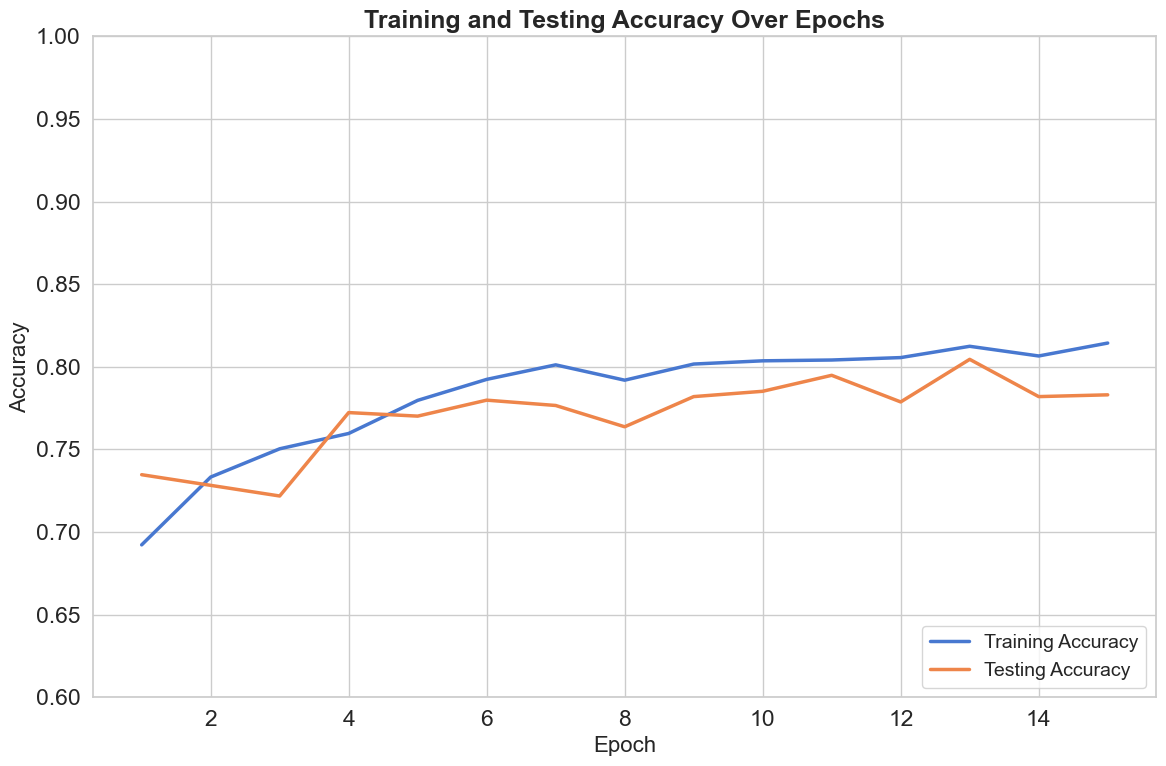

In [45]:
plot_training_testing_accuracy(data)

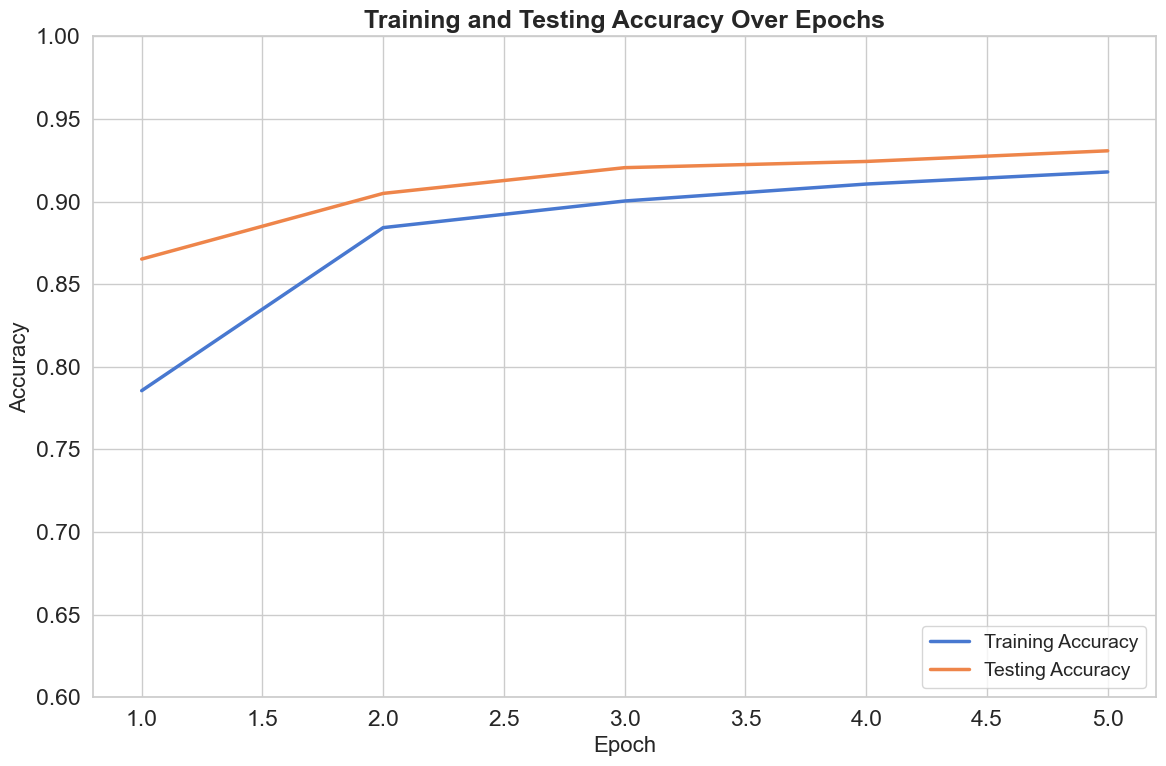

In [46]:
plot_training_testing_accuracy(data_pretrained)